In [ ]:
# Install packages

In [2]:
# Import libraries

import pandas as pd
import numpy as np
import rasterio
import glob
import os
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import rasterio
from rasterio.enums import Resampling
from tqdm import tqdm

In [4]:
# Define functions

def load_rgb_and_scl(safe_dir):
    rgb_paths = sorted(glob.glob(os.path.join(safe_dir, "GRANULE", "*", "IMG_DATA", "R10m", "*_B0[2-4]_10m.jp2")))
    scl_path = glob.glob(os.path.join(safe_dir, "GRANULE", "*", "IMG_DATA", "R20m", "*_SCL_20m.jp2"))[0]

    with rasterio.open(rgb_paths[0]) as r:
        profile = r.profile
        r_data = r.read(1)
    with rasterio.open(rgb_paths[1]) as g:
        g_data = g.read(1)
    with rasterio.open(rgb_paths[2]) as b:
        b_data = b.read(1)

    with rasterio.open(scl_path) as scl_src:
        scl = scl_src.read(
            1,
            out_shape=(1, profile["height"], profile["width"]),
            resampling=Resampling.nearest
        )

    rgb = np.stack([r_data, g_data, b_data], axis=-1)
    return rgb, scl, profile

def extract_paired_patches(cloudy_rgb, clear_rgb, scl, patch_size=256, stride=64, min_cloud=0.05, max_cloud=0.3):
    paired_patches = []
    h, w = scl.shape
    for i in range(0, h - patch_size, stride):
        for j in range(0, w - patch_size, stride):
            scl_patch = scl[i:i+patch_size, j:j+patch_size]
            cloud_mask = np.isin(scl_patch, [8, 9, 10])
            cloud_fraction = cloud_mask.sum() / (patch_size * patch_size)

            if min_cloud <= cloud_fraction <= max_cloud:
                cloudy_patch = cloudy_rgb[i:i+patch_size, j:j+patch_size, :]
                clear_patch = clear_rgb[i:i+patch_size, j:j+patch_size, :]
                paired_patches.append((cloudy_patch, clear_patch, scl_patch, cloud_fraction))
    return paired_patches

In [112]:
# Get paired 128x128 pixel patches

cloudy_rgb, scl, _ = load_rgb_and_scl("/Users/tessacannon/Documents/UCL/AI4EO/Cloud Removal Project/temp/cloudy/pair_0000_cloudy/S2B_MSIL2A_20240304T212519_N0510_R043_T07WDS_20240304T222852.SAFE")
clear_rgb, _, _ = load_rgb_and_scl("/Users/tessacannon/Documents/UCL/AI4EO/Cloud Removal Project/temp/clear/pair_0000_clear/S2A_MSIL2A_20240312T213531_N0510_R086_T07WDS_20240313T010449.SAFE")  

paired_patches = extract_paired_patches(cloudy_rgb, clear_rgb, scl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.454..1.5504].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.2874..1.6055].


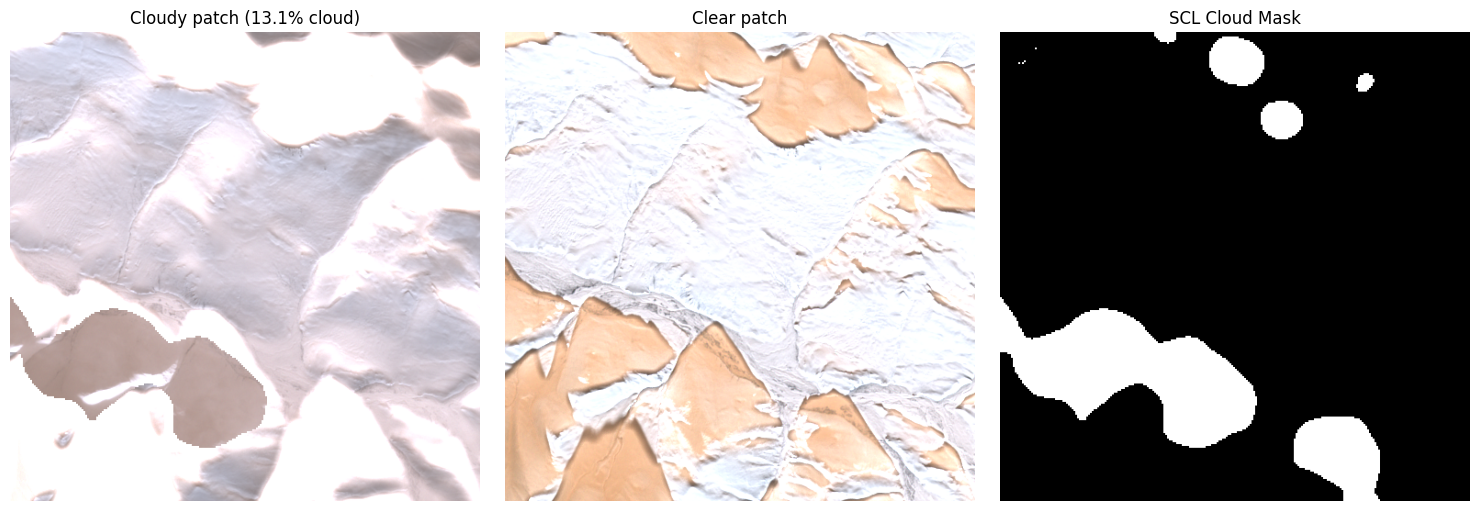

In [113]:
# Visuallize inspect patches

cloudy_patch, clear_patch, scl_patch, frac = paired_patches[400]
cloud_mask = np.isin(scl_patch, [8, 9, 10])  # Binary cloud mask

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cloudy_patch/10000)
axes[0].set_title(f"Cloudy patch ({frac:.1%} cloud)")
axes[0].axis("off")

axes[1].imshow(clear_patch/10000)
axes[1].set_title("Clear patch")
axes[1].axis("off")

axes[2].imshow(cloud_mask, cmap="gray")
axes[2].set_title("SCL Cloud Mask")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [114]:
# Count the number of paired patches

len(paired_patches)

4976

In [6]:
# Create patch folders for all extracted pairs

base_dir = "/Users/tessacannon/Documents/UCL/AI4EO/Cloud Removal Project/temp"
cloudy_dir = os.path.join(base_dir, "cloudy")
clear_dir = os.path.join(base_dir, "clear")

cloudy_patch_out = os.path.join(base_dir, "cloudy_patches")
clear_patch_out = os.path.join(base_dir, "clear_patches")
os.makedirs(cloudy_patch_out, exist_ok=True)
os.makedirs(clear_patch_out, exist_ok=True)

# Get list of pairs (assuming matched IDs like pair_0001_clear/cloudy)
pair_ids = sorted([d for d in os.listdir(cloudy_dir) if d.startswith("pair_")])

for pair_id in tqdm(pair_ids, desc="Processing pairs"):
    pair_index = pair_id.split("_")[1]  # e.g., "0002"
    cloudy_path = os.path.join(cloudy_dir, f"pair_{pair_index}_cloudy")
    clear_path = os.path.join(clear_dir, f"pair_{pair_index}_clear")

    # Find the SAFE directory inside each pair folder
    cloudy_safe = glob.glob(os.path.join(cloudy_path, "*.SAFE"))[0]
    clear_safe = glob.glob(os.path.join(clear_path, "*.SAFE"))[0]

    try:
        cloudy_rgb, scl, _ = load_rgb_and_scl(cloudy_safe)
        clear_rgb, _, _ = load_rgb_and_scl(clear_safe)
        paired_patches = extract_paired_patches(cloudy_rgb, clear_rgb, scl)

        for idx, (cloudy_patch, clear_patch, scl_patch, cloud_frac) in enumerate(paired_patches):
            patch_id = f"patch_{pair_index}_{idx:03d}"
            np.save(os.path.join(cloudy_patch_out, patch_id + ".npy"), cloudy_patch)
            np.save(os.path.join(clear_patch_out, patch_id + ".npy"), clear_patch)

    except Exception as e:
        print(f"Error processing {pair_id}: {e}")


Processing pairs: 100%|██████████| 13/13 [10:34<00:00, 48.83s/it]


In [8]:
# get number of patches saved
cloudy_files = len(glob.glob(os.path.join(cloudy_patch_out, "*.npy")))
print(f"Number of cloudy-clear patch pairs: {cloudy_files}")

Number of cloudy-clear patch pairs: 37661
